In [1]:
from transformers import pipeline
import torch
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Replace 'file_path.pkl' with the path to your .pkl file
df = pd.read_pickle("../results_2024_11_01_171511/articles.pkl")

In [3]:
# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(3)

,PMC11221914,PMC11034606,PMC11034585,PMC11034587,PMC11034592,PMC11034589,PMC11034583,PMC11034588,PMC11304160,PMC11015502
TITLE,[Cognitive Symptoms in Cross-Sectional Parkins...,[Potential role of hippocampal neurogenesis in...,[Metabolic reprogramming of the inflammatory r...,[Efficacy of exercise rehabilitation for manag...,[Unraveling the gut-brain axis: the impact of ...,[Glyphosate as a direct or indirect activator ...,"[Endoplasmic reticulum stress, autophagy, neur...",[Oligodendrocytes in central nervous system di...,[Emerging role of sirtuins in non‑small cell l...,[Effects of exercise interventions on brain-de...
ABSTRACT,"[Background and Objectives, Cognitive impairme...",[It has been reported both in clinic and roden...,[Metabolism is a fundamental process by which ...,[Alzheimer’s disease (AD) is a progressive and...,[This comprehensive review explores the intric...,[Glyphosate-based herbicides are widely used a...,[The etiological factors contributing to depre...,"[Cytokines including tumor necrosis factor, in...",[Non-small cell lung cancer (NSCLC) is a highl...,"[Background, /Objective. An explosion in globa..."
INTRO,"[Introduction, Cognitive impairment in Parkins...","[Introduction, Spinal cord injury (SCI) is a h...","[Introduction, Metabolism and inflammation are...","[Introduction, Alzheimer’s disease (AD) is a c...","[Introduction, Background and significance of ...","[Introduction, Glyphosate-based herbicides (GB...","[Introduction, Major depression is a debilitat...","[Introduction, Oligodendrocytes (OLs) are the ...","[Introduction, Sirtuins (SIRTs) are members of...","[Introduction, Global prevalence of obesity an..."


In [4]:
# transpose the dataframe and add an index column
df = df.T.reset_index()
df.head()

,index,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11221914,[Cognitive Symptoms in Cross-Sectional Parkins...,"[Background and Objectives, Cognitive impairme...","[Introduction, Cognitive impairment in Parkins...",[],"[Methods, Standard Protocol Approvals, Registr...","[Results, A total of 25,192 Fox Insight partic...","[Discussion, Cognitive problems as a most both...",[]
1,PMC11034606,[Potential role of hippocampal neurogenesis in...,[It has been reported both in clinic and roden...,"[Introduction, Spinal cord injury (SCI) is a h...",[],[],[],"[Conclusions and Perspectives, SCI-induced pos...",[]
2,PMC11034585,[Metabolic reprogramming of the inflammatory r...,[Metabolism is a fundamental process by which ...,"[Introduction, Metabolism and inflammation are...",[],[],[],[],"[Conclusions, Metabolic reprogramming of the i..."
3,PMC11034587,[Efficacy of exercise rehabilitation for manag...,[Alzheimer’s disease (AD) is a progressive and...,"[Introduction, Alzheimer’s disease (AD) is a c...",[],[],[],"[Conclusions and Future Perspectives, Exercise...",[]
4,PMC11034592,[Unraveling the gut-brain axis: the impact of ...,[This comprehensive review explores the intric...,"[Introduction, Background and significance of ...",[],[],[],[],"[Conclusions, Summary of the main findings, Th..."


In [5]:
# change the first column name to 'article_id'
df = df.rename(columns={"index": "article_id"})
df.head()

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11221914,[Cognitive Symptoms in Cross-Sectional Parkins...,"[Background and Objectives, Cognitive impairme...","[Introduction, Cognitive impairment in Parkins...",[],"[Methods, Standard Protocol Approvals, Registr...","[Results, A total of 25,192 Fox Insight partic...","[Discussion, Cognitive problems as a most both...",[]
1,PMC11034606,[Potential role of hippocampal neurogenesis in...,[It has been reported both in clinic and roden...,"[Introduction, Spinal cord injury (SCI) is a h...",[],[],[],"[Conclusions and Perspectives, SCI-induced pos...",[]
2,PMC11034585,[Metabolic reprogramming of the inflammatory r...,[Metabolism is a fundamental process by which ...,"[Introduction, Metabolism and inflammation are...",[],[],[],[],"[Conclusions, Metabolic reprogramming of the i..."
3,PMC11034587,[Efficacy of exercise rehabilitation for manag...,[Alzheimer’s disease (AD) is a progressive and...,"[Introduction, Alzheimer’s disease (AD) is a c...",[],[],[],"[Conclusions and Future Perspectives, Exercise...",[]
4,PMC11034592,[Unraveling the gut-brain axis: the impact of ...,[This comprehensive review explores the intric...,"[Introduction, Background and significance of ...",[],[],[],[],"[Conclusions, Summary of the main findings, Th..."


In [ ]:
# save the dataframe to a .csv file
# df.to_csv(
#     "articles.csv", index=False
# )

In [7]:
# Method to recreate the articles minus the abstracts
def combine_columns(df):
    """
    Combines the text from multiple columns into a single column for natural language processing.

    Args:
      df: A pandas DataFrame with columns 'article_id', 'TITLE', 'INTRO', 'CASE', 'METHODS', 'RESULTS', 'DISCUSS', 'CONCL'.

    Returns:
      A pandas DataFrame with a new column 'full_text' containing the combined text.
    """

    df["full_text"] = df.apply(
        lambda row: " ".join(
            [
                str(row["TITLE"]),
                str(row["INTRO"]),
                str(row["CASE"]),
                str(row["METHODS"]),
                str(row["RESULTS"]),
                str(row["DISCUSS"]),
                str(row["CONCL"]),
            ]
        ),
        axis=1,
    )
    return df

In [8]:
df_articles = combine_columns(df)
df_articles.head()

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11221914,[Cognitive Symptoms in Cross-Sectional Parkins...,"[Background and Objectives, Cognitive impairme...","[Introduction, Cognitive impairment in Parkins...",[],"[Methods, Standard Protocol Approvals, Registr...","[Results, A total of 25,192 Fox Insight partic...","[Discussion, Cognitive problems as a most both...",[],['Cognitive Symptoms in Cross-Sectional Parkin...
1,PMC11034606,[Potential role of hippocampal neurogenesis in...,[It has been reported both in clinic and roden...,"[Introduction, Spinal cord injury (SCI) is a h...",[],[],[],"[Conclusions and Perspectives, SCI-induced pos...",[],['Potential role of hippocampal neurogenesis i...
2,PMC11034585,[Metabolic reprogramming of the inflammatory r...,[Metabolism is a fundamental process by which ...,"[Introduction, Metabolism and inflammation are...",[],[],[],[],"[Conclusions, Metabolic reprogramming of the i...",['Metabolic reprogramming of the inflammatory ...
3,PMC11034587,[Efficacy of exercise rehabilitation for manag...,[Alzheimer’s disease (AD) is a progressive and...,"[Introduction, Alzheimer’s disease (AD) is a c...",[],[],[],"[Conclusions and Future Perspectives, Exercise...",[],['Efficacy of exercise rehabilitation for mana...
4,PMC11034592,[Unraveling the gut-brain axis: the impact of ...,[This comprehensive review explores the intric...,"[Introduction, Background and significance of ...",[],[],[],[],"[Conclusions, Summary of the main findings, Th...",['Unraveling the gut-brain axis: the impact of...


In [9]:
import textwrap

wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

In [10]:
# Method to print the full text of a single article by article_id
def print_article(df, article_id):
    """
    Prints the full text of a single article in a readable format.

    Args:
      df: A pandas DataFrame with a 'full_text' column and an 'article_id' column.
      article_id: The ID of the article to print.
    """

    article = df[df["article_id"] == article_id]["full_text"].values[0]

    # Remove string and list characters from the text
    cleaned_text = article.replace("[", "").replace("]", "").replace("'", "")
    print(wrapper.fill(cleaned_text))


print_article(df_articles, "PMC11221914")

Cognitive Symptoms in Cross-Sectional Parkinson Disease Cohort Evaluated by
Human-in-the-Loop Machine Learning and Natural Language Processing Introduction,
Cognitive impairment in Parkinson disease (PD) is heterogeneous and associated
with poor quality of life (QoL) for both people with PD and care partners. What
is known about cognition in PD is largely derived from cognitive screening
instruments or neuropsychological testing. The frequency of cognitive impairment
as measured by neuropsychological tests and cognitive screening instruments
increases with disease duration and severity, but differences in cognitive
performance on neuropsychological tests as compared with non-PD controls can be
detected even early in PD. Different cognitive profiles of cognitive impairment
in PD have been defined. Yet, what patients with PD experience and report in
their own words as cognitive impairment symptoms has been examined in very few
studies involving small numbers of patients., We have develop

In [11]:
# print article abstract
def print_abstract(df, article_id):
    """
    Prints the abstract of a single article in a readable format.

    Args:
      df: A pandas DataFrame with an 'article_id' column and a 'ABSTRACT' column.
      article_id: The ID of the article to print.
    """

    abstract = df[df["article_id"] == article_id]["ABSTRACT"].values[0]
    # convert abstract list of strings to string
    abstract = " ".join(abstract)
    print(wrapper.fill(abstract))


print_abstract(df, "PMC11221914")

Background and Objectives Cognitive impairment is experienced by up to 80% of
people with Parkinson disease (PD). Little is known regarding the subjective
experience and frequency of bothersome cognitive problems across the range of
disease duration as expressed directly in patients' own words. We describe the
types and frequency of bothersome cognitive symptoms reported verbatim by
patients with PD. Methods Through the online Fox Insight study and the Parkinson
Disease Patient Report of Problems, we asked patients with PD to self-report by
keyboard entry up to five most bothersome problems and how these problems affect
their functioning. Human-in-the-loop curation, natural language processing, and
machine learning were used to categorize responses into 8 cognitive symptoms:
memory, concentration/attention, cognitive slowing, language/word finding,
mental alertness/awareness, visuospatial abilities, executive abilities/working
memory, and cognitive impairment not otherwise specified. A

In [12]:
# For windows GPU support
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# For MacOS GPU support
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [13]:
# Summarize the first article using the BART model
pipe = pipeline("summarization", model="facebook/bart-large-cnn", device=device)
output = pipe(df["full_text"][0], max_length=130, min_length=30)
summary = output[0]["summary_text"]
print(wrapper.fill(summary))

Cognitive impairment in Parkinson disease (PD) is heterogeneous and associated
with poor quality of life for both people with PD and care partners. What
patients with PD experience and report in their own words has been examined in
very few studies involving small numbers of patients. We have developed machine
learning algorithms based on natural language processing, machine learning, and
human-in-the-loop curation to classify problems in PD.


In [14]:
# Evaluate the BART model on the first article
rouge = evaluate.load("rouge")
bart_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bart_scores)

{'rouge1': 0.41860465116279066, 'rouge2': 0.14173228346456693, 'rougeL': 0.23809523809523808, 'rougeLsum': 0.23809523809523808}


In [15]:
# Summarize all articles using the Falconsai/medical_summarization
pipe = pipeline("summarization", model="Falconsai/medical_summarization", device=device)
output = pipe(df["full_text"][0])
summary = output[0]["summary_text"]
print(summary)

Token indices sequence length is longer than the specified maximum sequence length for this model (5253 > 512). Running this sequence through the model will result in indexing errors


objective cognitive impairment in Parkinson disease ( PD) is associated with poor quality of life (QoL) for both people with PD and care partners . this study aimed to investigate the prevalence of subjective cognitive complaints in PD . a large sample (>25,000 participants ) and unconstrained free text reporting of problems was used to assess the frequency and nature of cognitive problems in a remarkably large cohort of patients with varying disease duration and severity . we found that a wide range of cognitive complaints based on age , sex, YSD, education, depression, and cholinergic loss.resultsa total of 3441 patients reported at least one cognitive symptom as a most bothersome problem compared with those younger than 50 years . in the first year after a diagnosis of PD ( p  0.001 ) were reported in the p0.001 (


In [16]:
# Evaluate the Falconsai/medical_summarization model on the first article
falconsai_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(falconsai_scores)

{'rouge1': 0.37037037037037035, 'rouge2': 0.0962566844919786, 'rougeL': 0.24338624338624337, 'rougeLsum': 0.24338624338624337}


In [17]:
# Summarize all articles using the google/bigbird-pegasus-large-arxiv model
pipe = pipeline(
    "summarization", model="google/bigbird-pegasus-large-arxiv", device=device
)
output = pipe(df["full_text"][0])
summary = output[0]["summary_text"]
print(summary)

model.safetensors:   0%|          | 0.00/2.31G [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4510 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 4510 to 4544 to be a multiple of `config.block_size`: 64


cognitive impairment is one of the key markers of the ageing process . yet it is still poorly understood , particularly in the first place , what causes it and how it can be corrected . here<n> we report on a systematic study of the impact of cognitive impairment on the quality of life of individuals with a wide range of complex cognitive impairment .<n> we show that the quality of life of individuals with a wide range of cognitive impairment depends not only on their ability to retain memory , but also on their ability to retain information .<n> specifically , we show that the fraction of information that is retained by an individual increases with his or her ability to retain cognitive information .<n> we also show that the fraction of information that is retained by an individual decreases with his or her ability to retain information increases with his or her ability to retain visual information . <n> cognitive impairment is one of the key markers of the ageing process . yet it is 

In [18]:
# Evaluate the google/bigbird-pegasus-large-arxiv model on the first article
bigbird_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bigbird_scores)

{'rouge1': 0.16428571428571428, 'rouge2': 0.03558718861209965, 'rougeL': 0.1285714285714286, 'rougeLsum': 0.1285714285714286}


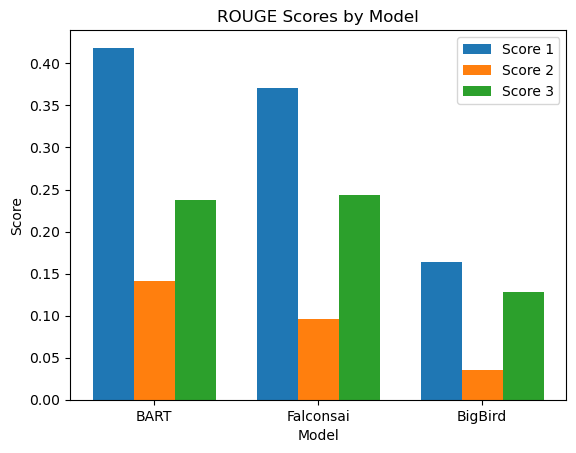

In [19]:
# Create a chart to compare the scores

models = ["BART", "Falconsai", "BigBird"]
scores_1 = [bart_scores["rouge1"], falconsai_scores["rouge1"], bigbird_scores["rouge1"]]
scores_2 = [bart_scores["rouge2"], falconsai_scores["rouge2"], bigbird_scores["rouge2"]]
scores_l = [bart_scores["rougeL"], falconsai_scores["rougeL"], bigbird_scores["rougeL"]]
scores = [scores_1, scores_2, scores_l]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(models))

for i, score in enumerate(scores):
    ax.bar([x + bar_width * i for x in index], score, bar_width, label=f"Score {i + 1}")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("ROUGE Scores by Model")
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [45]:
# extract the article_id, abstract, and full_text columns into a new DataFrame
df_nlp = df_articles[["article_id", "full_text", "ABSTRACT"]]
df_nlp.head()

,article_id,full_text,ABSTRACT
0,PMC11221914,['Cognitive Symptoms in Cross-Sectional Parkin...,"[Background and Objectives, Cognitive impairme..."
1,PMC11034606,['Potential role of hippocampal neurogenesis i...,[It has been reported both in clinic and roden...
2,PMC11034585,['Metabolic reprogramming of the inflammatory ...,[Metabolism is a fundamental process by which ...
3,PMC11034587,['Efficacy of exercise rehabilitation for mana...,[Alzheimer’s disease (AD) is a progressive and...
4,PMC11034592,['Unraveling the gut-brain axis: the impact of...,[This comprehensive review explores the intric...


In [46]:
# Remove string and list characters from the full_text column
df_nlp.loc[:, "full_text"] = df_nlp["full_text"].apply(
    lambda x: x.replace("[", "").replace("]", "").replace("'", "").strip()
)

# Convert the ABSTRACT column from a list of strings to a single string and strip leading and trailing whitespace
df_nlp.loc[:, "ABSTRACT"] = df_nlp["ABSTRACT"].apply(lambda x: " ".join(x).strip())


df_nlp.head(3)

,article_id,full_text,ABSTRACT
0,PMC11221914,Cognitive Symptoms in Cross-Sectional Parkinso...,Background and Objectives Cognitive impairment...
1,PMC11034606,Potential role of hippocampal neurogenesis in ...,It has been reported both in clinic and rodent...
2,PMC11034585,Metabolic reprogramming of the inflammatory re...,Metabolism is a fundamental process by which b...


In [48]:
# save the dataframe to a .csv file
df_nlp.to_csv(
    "articles.csv", index=False
)

array([[<Axes: title={'center': 'full_text_length'}>,
        <Axes: title={'center': 'abstract_length'}>]], dtype=object)

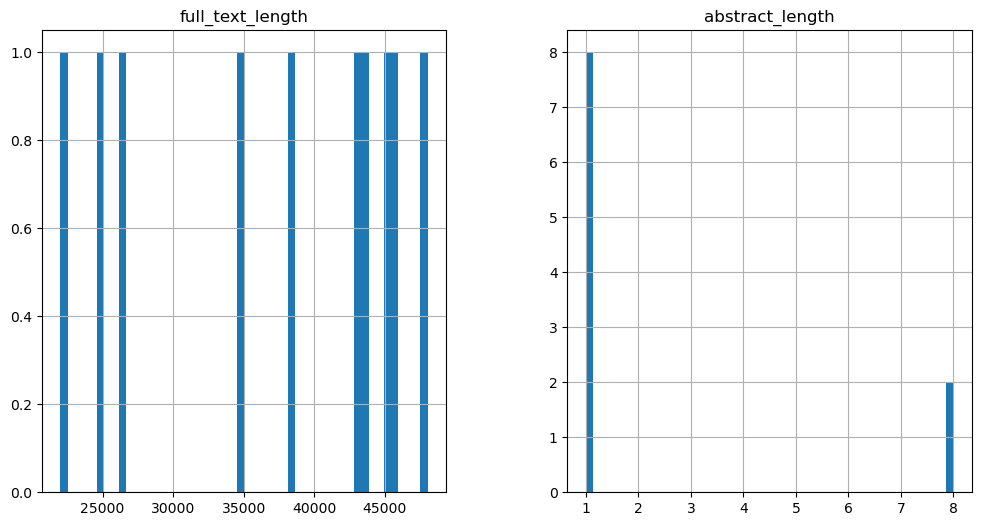

In [21]:
# create two lists 'full_text_length' and 'abstract_length' to store the length of each article and its abstract
full_text_length = []
abstract_length = []

# iterate through each row in the DataFrame
for index, row in df_nlp.iterrows():
    # calculate the length of the 'full_text' and 'ABSTRACT' columns
    full_text_length.append(len(row["full_text"]))
    abstract_length.append(len(row["ABSTRACT"]))

data = pd.DataFrame([full_text_length, abstract_length]).T
data.columns = ["full_text_length", "abstract_length"]

data.hist(bins=50, figsize=(12, 6))

In [22]:
X = df_nlp["full_text"]
y = df_nlp["ABSTRACT"]

# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## To do: Fine-tuning LLM for our use case